##### Imports

In [1]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
import cv2
from PIL import Image

# For Grad-CAM visualization
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

##### Seed Setting and Reproducibility

In [2]:
def set_seed(seed: int = 42):
    """Set random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: mps


##### Data Augmentation and Preprocessing

In [3]:
# Training augmentation - aggressive for medical images
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Brain is symmetric
    transforms.RandomRotation(15),  # Slight rotation variations
    # MRI intensity variations
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Slight shifts
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # ImageNet stats
])

# Validation/Test - no augmentation
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

##### Custom Dataset Loading

In [4]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        for class_name in self.classes:
            class_dir = os.path.join(self.root_dir, class_name)
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.endswith(('.jpg', '.jpeg', '.png')):
                        img_path = os.path.join(class_dir, img_name)
                        samples.append(
                            (img_path, self.class_to_idx[class_name]))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Load and split data into train/val/test sets
def load_data(data_dir, batch_size=32, val_split=0.2):
    # Load training data
    train_dir = os.path.join(data_dir, 'Train')
    full_train_dataset = BrainTumorDataset(
        train_dir, transform=train_transform)

    # Split into train and validation
    train_size = int((1 - val_split) * len(full_train_dataset))
    val_size = len(full_train_dataset) - train_size
    train_dataset, val_dataset = random_split(
        full_train_dataset, [train_size, val_size])

    # Load test data
    test_dir = os.path.join(data_dir, 'Test')
    test_dataset = BrainTumorDataset(test_dir, transform=val_test_transform)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                            shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=False, pin_memory=True)

    class_names = full_train_dataset.classes

    print(f"Train size: {len(train_dataset)}")
    print(f"Validation size: {len(val_dataset)}")
    print(f"Test size: {len(test_dataset)}")
    print(f"Classes: {class_names}")

    return train_loader, val_loader, test_loader, class_names

##### CNN Architecture

In [5]:
class BrainTumorCNN(nn.Module):
    """
    Custom CNN for Brain Tumor Classification

    Architecture:
    - Block 1: Conv32 → BN → ReLU → Conv32 → BN → ReLU → MaxPool → Dropout(0.25)
    - Block 2: Conv64 → BN → ReLU → Conv64 → BN → ReLU → MaxPool → Dropout(0.25)
    - Block 3: Conv128 → BN → ReLU → Conv128 → BN → ReLU → MaxPool → Dropout(0.3)
    - Block 4: Conv256 → BN → ReLU → Conv256 → BN → ReLU → MaxPool → Dropout(0.3)
    - GlobalAvgPool → FC512 → BN → ReLU → Dropout(0.5) → FC(num_classes)
    """

    def __init__(self, num_classes=4):
        super(BrainTumorCNN, self).__init__()

        # Block 1: 32 filters
        self.conv1_1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(32)
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        # Block 2: 64 filters
        self.conv2_1 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(64)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        # Block 3: 128 filters
        self.conv3_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(128)
        self.conv3_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.3)

        # Block 4: 256 filters
        self.conv4_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4_1 = nn.BatchNorm2d(256)
        self.conv4_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4_2 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout(0.3)

        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Fully Connected Layers
        self.fc1 = nn.Linear(256, 512)
        self.bn_fc = nn.BatchNorm1d(512)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = F.relu(self.bn1_2(self.conv1_2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Block 2
        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Block 3
        x = F.relu(self.bn3_1(self.conv3_1(x)))
        x = F.relu(self.bn3_2(self.conv3_2(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        # Block 4
        x = F.relu(self.bn4_1(self.conv4_1(x)))
        x = F.relu(self.bn4_2(self.conv4_2(x)))
        x = self.pool4(x)
        x = self.dropout4(x)

        # Global Average Pooling
        x = self.gap(x)
        x = x.view(x.size(0), -1)

        # Fully Connected
        x = F.relu(self.bn_fc(self.fc1(x)))
        x = self.dropout_fc(x)
        x = self.fc2(x)

        return x

##### Training and Evaluation Helpers

In [6]:
def train_one_epoch(model, loader, criterion, optimizer, device, epoch=None, total_epochs=None):
    """Train model for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    total_batches = len(loader)

    for batch_idx, (inputs, labels) in enumerate(loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print progress every 10% of batches
        if (batch_idx + 1) % max(1, total_batches // 10) == 0 or (batch_idx + 1) == total_batches:
            progress = 100.0 * (batch_idx + 1) / total_batches
            current_loss = running_loss / total
            current_acc = correct / total
            if epoch is not None:
                print(f"  Epoch [{epoch}/{total_epochs}] - Batch [{batch_idx+1}/{total_batches}] "
                      f"({progress:.0f}%) - Loss: {current_loss:.4f} - Acc: {current_acc*100:.2f}%")

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc, all_preds, all_labels, all_probs

##### Computing Metric Helpers

In [7]:
def compute_metrics(y_true, y_pred, y_probs, class_names):
    """
    Compute comprehensive metrics

    Returns:
        Dictionary containing all metrics
    """
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)

    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(len(class_names))
    )

    # Weighted averages
    precision_avg, recall_avg, f1_avg, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted'
    )

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # AUC scores (one-vs-rest)
    y_probs_array = np.array(y_probs)
    y_true_binary = np.eye(len(class_names))[y_true]

    auc_scores = []
    for i in range(len(class_names)):
        try:
            auc = roc_auc_score(y_true_binary[:, i], y_probs_array[:, i])
            auc_scores.append(auc)
        except:
            auc_scores.append(0.0)

    metrics = {
        'accuracy': accuracy,
        'precision_per_class': precision,
        'recall_per_class': recall,
        'f1_per_class': f1,
        'support_per_class': support,
        'precision_avg': precision_avg,
        'recall_avg': recall_avg,
        'f1_avg': f1_avg,
        'confusion_matrix': cm,
        'auc_per_class': auc_scores,
        'auc_avg': np.mean(auc_scores)
    }

    return metrics


def print_metrics_report(metrics, class_names):
    """Print formatted metrics report"""
    print("\n" + "="*70)
    print("CLASSIFICATION METRICS REPORT")
    print("="*70)

    print(f"\nOverall Accuracy: {metrics['accuracy']:.4f}")
    print(f"Weighted Precision: {metrics['precision_avg']:.4f}")
    print(f"Weighted Recall: {metrics['recall_avg']:.4f}")
    print(f"Weighted F1-Score: {metrics['f1_avg']:.4f}")
    print(f"Average AUC: {metrics['auc_avg']:.4f}")

    print("\n" + "-"*70)
    print("Per-Class Metrics:")
    print("-"*70)
    print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10} {'AUC':<10}")
    print("-"*70)

    for i, class_name in enumerate(class_names):
        print(f"{class_name:<15} "
              f"{metrics['precision_per_class'][i]:<12.4f} "
              f"{metrics['recall_per_class'][i]:<12.4f} "
              f"{metrics['f1_per_class'][i]:<12.4f} "
              f"{metrics['support_per_class'][i]:<10} "
              f"{metrics['auc_per_class'][i]:<10.4f}")

    print("="*70)

##### Visualization Helpers

In [8]:
def plot_training_history(train_losses, val_losses, train_accs, val_accs, save_path='training_history.png'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    epochs = range(1, len(train_losses) + 1)

    # Loss plot
    ax1.plot(epochs, train_losses, 'b-o', label='Training Loss', markersize=4)
    ax1.plot(epochs, val_losses, 'r-s', label='Validation Loss', markersize=4)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training vs Validation Loss',
                  fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(epochs, [acc*100 for acc in train_accs],
             'b-o', label='Training Accuracy', markersize=4)
    ax2.plot(epochs, [acc*100 for acc in val_accs], 'r-s',
             label='Validation Accuracy', markersize=4)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Training vs Validation Accuracy',
                  fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Training history saved to {save_path}")


def plot_confusion_matrix(cm, class_names, save_path='confusion_matrix.png'):
    plt.figure(figsize=(10, 8))

    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Proportion'})

    plt.title('Normalized Confusion Matrix',
              fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Confusion matrix saved to {save_path}")


def plot_roc_curves(y_true, y_probs, class_names, save_path='roc_curves.png'):
    y_probs_array = np.array(y_probs)
    y_true_binary = np.eye(len(class_names))[y_true]

    plt.figure(figsize=(10, 8))

    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_binary[:, i], y_probs_array[:, i])
        auc = roc_auc_score(y_true_binary[:, i], y_probs_array[:, i])
        plt.plot(
            fpr, tpr, label=f'{class_name} (AUC = {auc:.3f})', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves - Multi-Class Classification',
              fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"ROC curves saved to {save_path}")


def visualize_gradcam(model, images, labels, class_names, num_samples=4, save_path='gradcam_samples.png'):
    # Use the last convolutional layer for Grad-CAM
    target_layer = model.conv4_2

    # Initialize Grad-CAM
    cam = GradCAM(model=model, target_layers=[
                  target_layer])

    # Denormalize function
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    def denormalize(img):
        img = img.cpu().numpy().transpose(1, 2, 0)
        img = std * img + mean
        img = np.clip(img, 0, 1)
        return img

    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        probs = F.softmax(outputs, dim=1)

    # Create visualization
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for idx in range(min(num_samples, len(images))):
        img = images[idx].unsqueeze(0)
        true_label = labels[idx].item()
        pred_label = preds[idx].item()
        confidence = probs[idx, pred_label].item()

        # Generate Grad-CAM
        targets = [ClassifierOutputTarget(pred_label)]
        grayscale_cam = cam(input_tensor=img, targets=targets)
        grayscale_cam = grayscale_cam[0, :]

        # Denormalize image
        rgb_img = denormalize(images[idx])

        # Create visualization
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        # Plot original image
        axes[idx, 0].imshow(rgb_img)
        axes[idx, 0].set_title(
            f'Original\nTrue: {class_names[true_label]}', fontsize=10)
        axes[idx, 0].axis('off')

        # Plot Grad-CAM heatmap
        axes[idx, 1].imshow(grayscale_cam, cmap='jet')
        axes[idx, 1].set_title('Grad-CAM Heatmap', fontsize=10)
        axes[idx, 1].axis('off')

        # Plot overlay
        axes[idx, 2].imshow(visualization)
        axes[idx, 2].set_title(
            f'Overlay\nPred: {class_names[pred_label]}\nConf: {confidence:.3f}', fontsize=10)
        axes[idx, 2].axis('off')

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Grad-CAM visualization saved to {save_path}")

##### Main Training Loop


BRAIN TUMOR CLASSIFICATION - CUSTOM CNN

Loading data...
Train size: 18278
Validation size: 4570
Test size: 1311
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']

Initializing model...
Model parameters: 1,308,836

STARTING TRAINING
Batches per epoch: 572 (train), 143 (val)

Epoch [1/30] starting...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


  Epoch [1/30] - Batch [57/572] (10%) - Loss: 1.0176 - Acc: 55.48%
  Epoch [1/30] - Batch [114/572] (20%) - Loss: 0.9755 - Acc: 58.06%
  Epoch [1/30] - Batch [171/572] (30%) - Loss: 0.9371 - Acc: 59.96%
  Epoch [1/30] - Batch [228/572] (40%) - Loss: 0.9073 - Acc: 61.54%
  Epoch [1/30] - Batch [285/572] (50%) - Loss: 0.8900 - Acc: 62.45%
  Epoch [1/30] - Batch [342/572] (60%) - Loss: 0.8742 - Acc: 63.22%
  Epoch [1/30] - Batch [399/572] (70%) - Loss: 0.8646 - Acc: 63.73%
  Epoch [1/30] - Batch [456/572] (80%) - Loss: 0.8546 - Acc: 64.18%
  Epoch [1/30] - Batch [513/572] (90%) - Loss: 0.8410 - Acc: 64.87%
  Epoch [1/30] - Batch [570/572] (100%) - Loss: 0.8320 - Acc: 65.43%
  Epoch [1/30] - Batch [572/572] (100%) - Loss: 0.8320 - Acc: 65.43%
Epoch [ 1/30] Train Loss: 0.8320 | Train Acc: 65.43% | Val Loss: 1.0441 | Val Acc: 54.84%
  → New best model saved! (Val Acc: 54.84%)

Epoch [2/30] starting...
  Epoch [2/30] - Batch [57/572] (10%) - Loss: 0.7450 - Acc: 70.34%
  Epoch [2/30] - Batch [

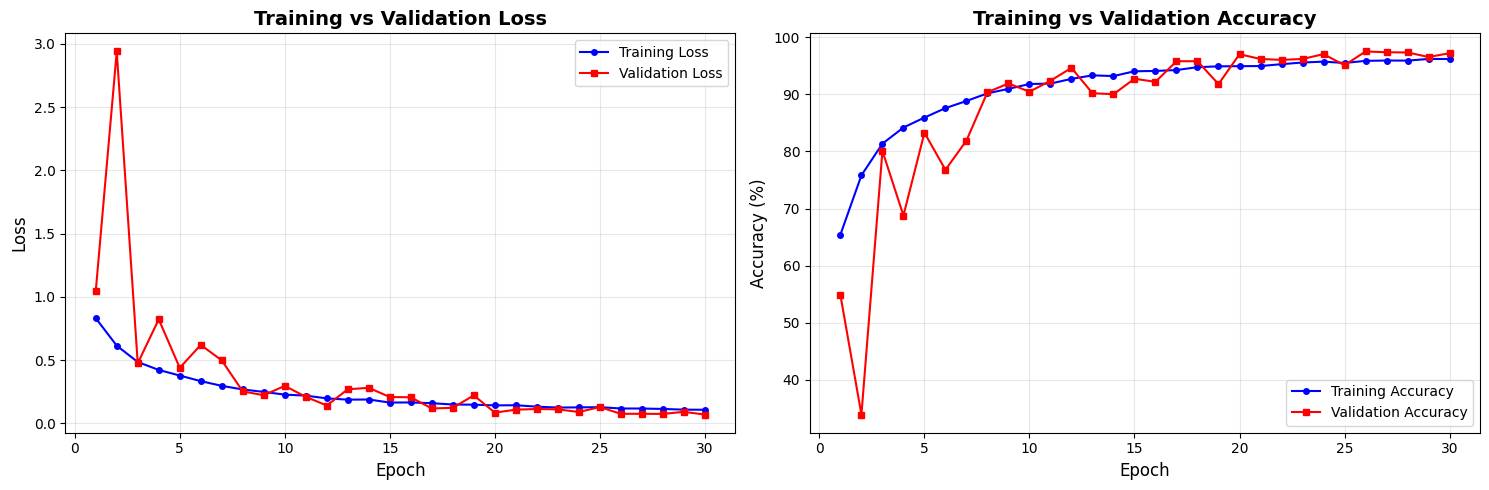

Training history saved to ./output/training_history.png

Loading best model for final evaluation...

FINAL TEST EVALUATION

Test Loss: 0.1344
Test Accuracy: 95.35%

Computing comprehensive metrics...

CLASSIFICATION METRICS REPORT

Overall Accuracy: 0.9535
Weighted Precision: 0.9547
Weighted Recall: 0.9535
Weighted F1-Score: 0.9529
Average AUC: 0.9973

----------------------------------------------------------------------
Per-Class Metrics:
----------------------------------------------------------------------
Class           Precision    Recall       F1-Score     Support    AUC       
----------------------------------------------------------------------
glioma          0.9894       0.9333       0.9605       300        0.9989    
meningioma      0.9568       0.8693       0.9110       306        0.9909    
notumor         0.9226       1.0000       0.9597       405        0.9997    
pituitary       0.9614       0.9967       0.9787       300        0.9996    

Generating confusion matrix

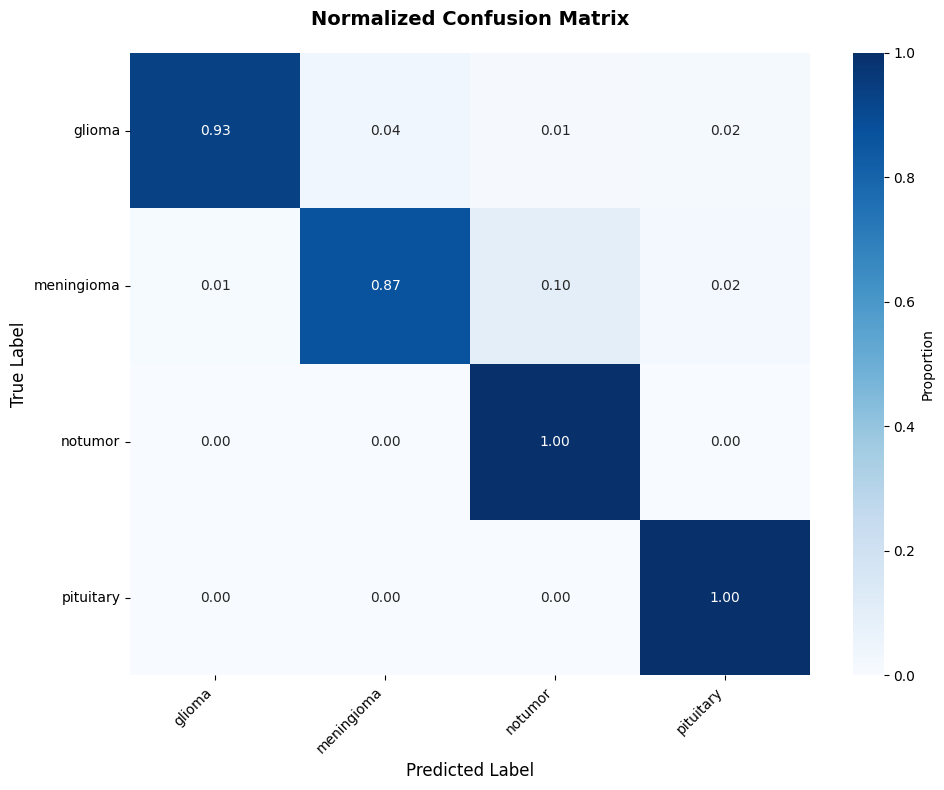

Confusion matrix saved to ./output/confusion_matrix.png

Generating ROC curves...


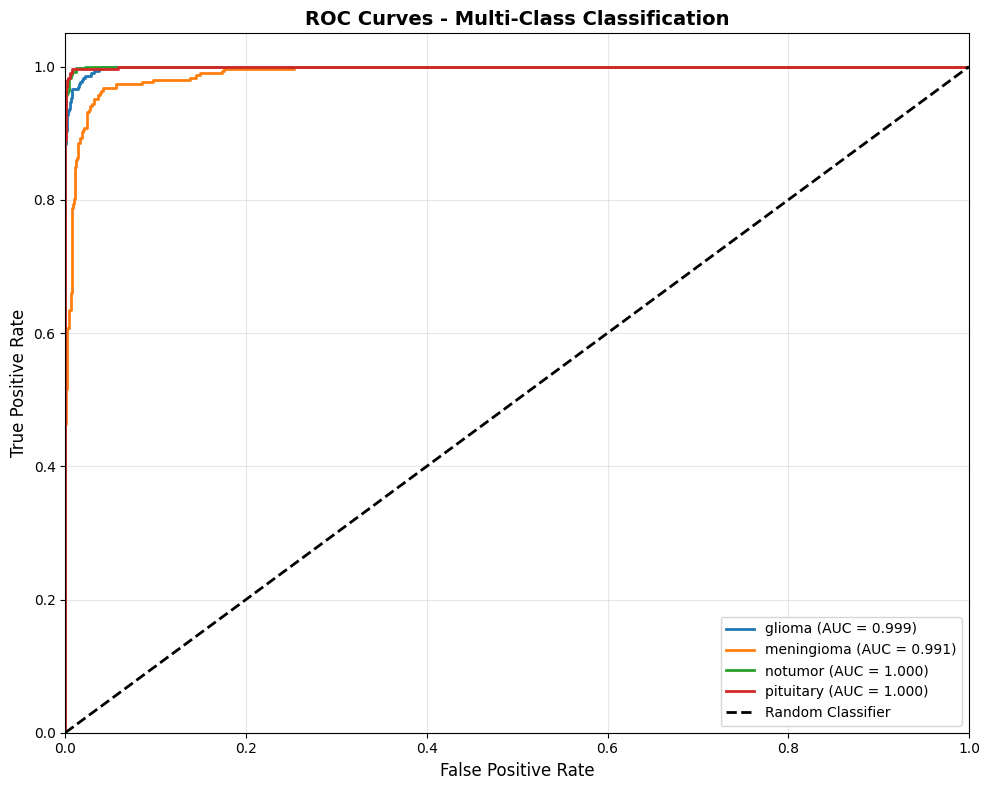

ROC curves saved to ./output/roc_curves.png

Generating Grad-CAM visualizations...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


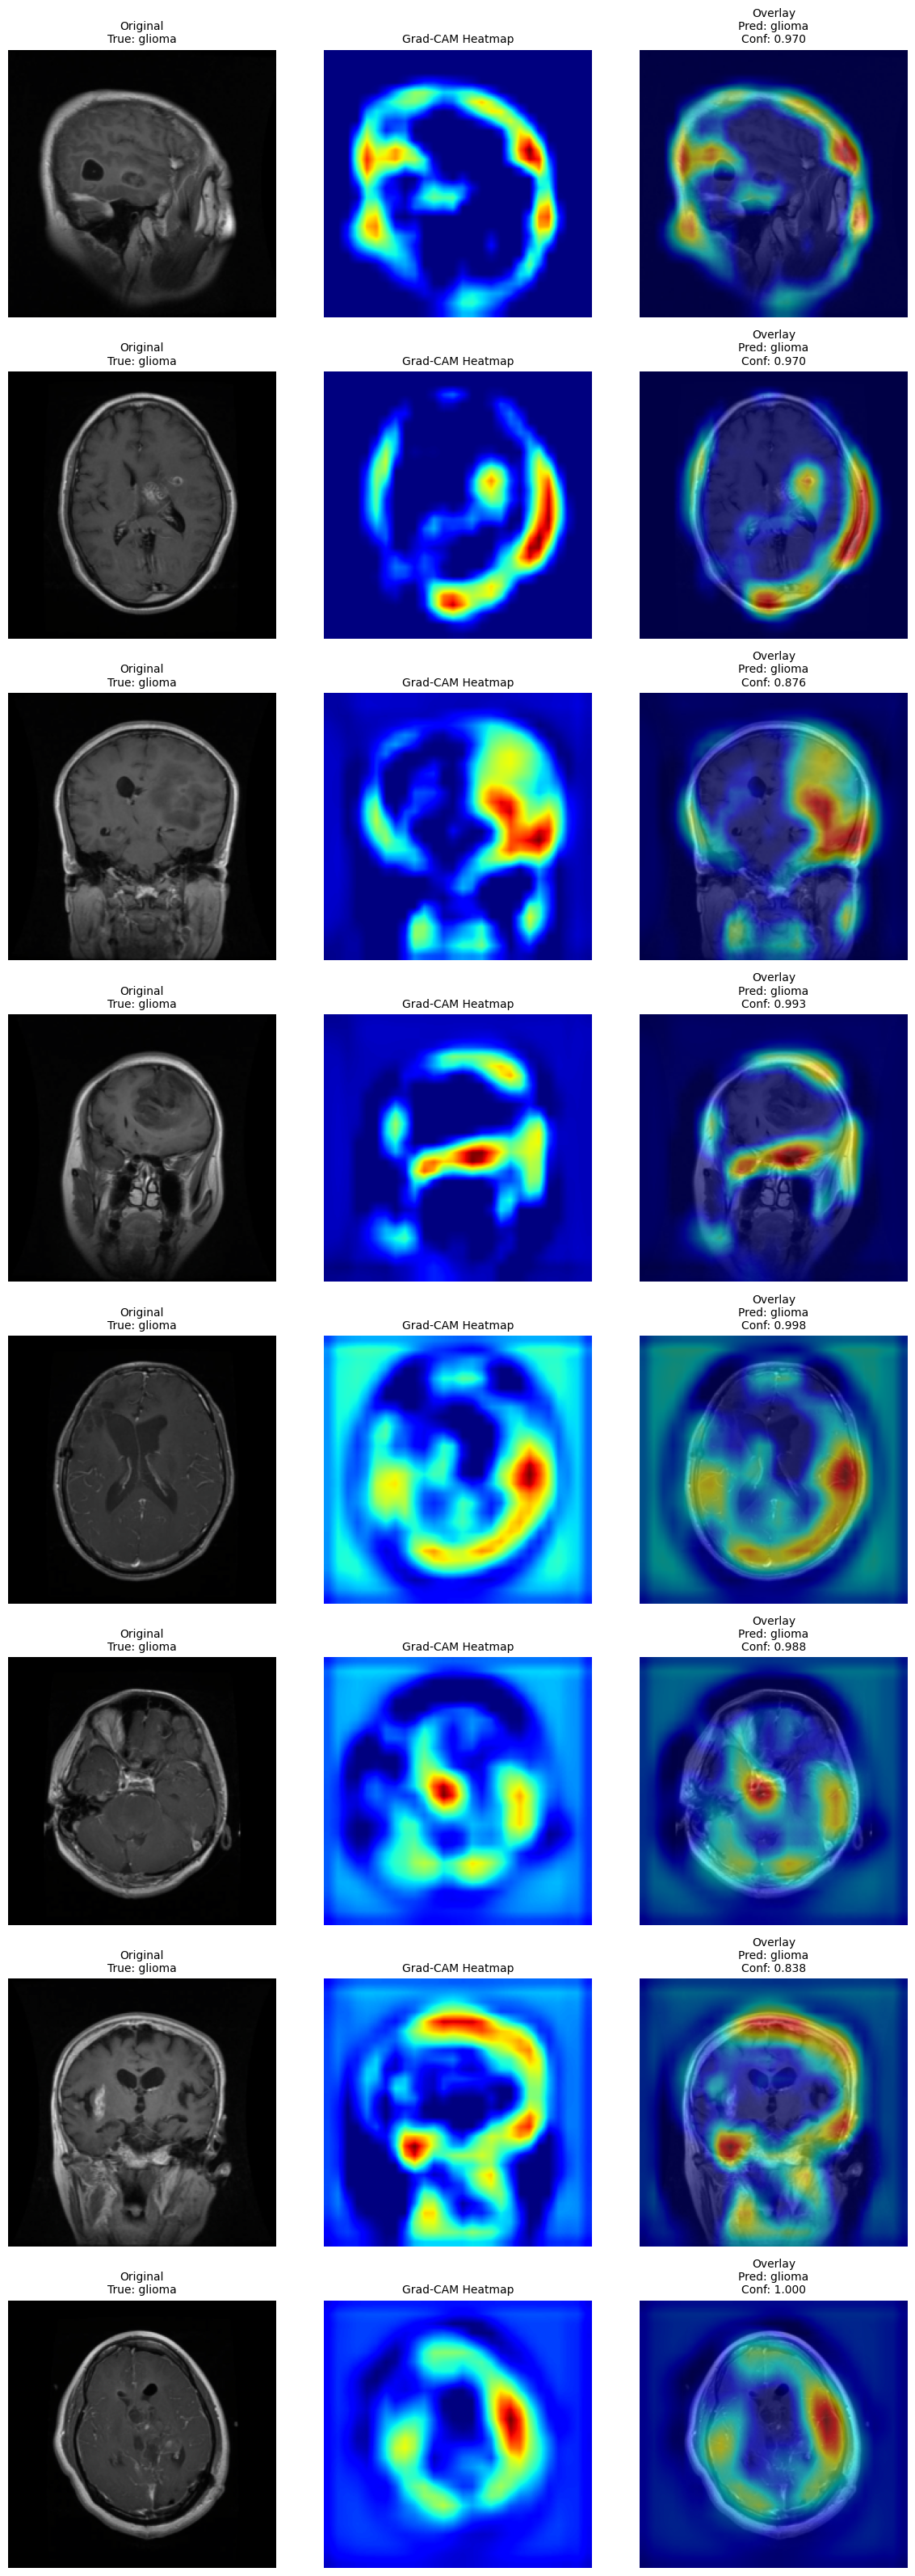

Grad-CAM visualization saved to ./output/gradcam_samples.png

TRAINING COMPLETE!

All outputs saved to: ./output/
Best Validation Accuracy: 97.51%
Final Test Accuracy: 95.35%


In [9]:
def main():
    # Hyperparameters
    BATCH_SIZE = 32
    EPOCHS = 30
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 1e-4  # L2 regularization

    # Data directory
    DATA_DIR = './data'

    # Create output directory
    OUTPUT_DIR = './output'
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    print("\n" + "="*70)
    print("BRAIN TUMOR CLASSIFICATION - CUSTOM CNN")
    print("="*70 + "\n")

    # Load data
    print("Loading data...")
    train_loader, val_loader, test_loader, class_names = load_data(
        DATA_DIR, batch_size=BATCH_SIZE
    )

    # Initialize model
    print("\nInitializing model...")
    model = BrainTumorCNN(num_classes=len(class_names)).to(device)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )

    # Training history
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0.0

    print("\n" + "="*70)
    print("STARTING TRAINING")
    print("="*70)
    print(
        f"Batches per epoch: {len(train_loader)} (train), {len(val_loader)} (val)")

    # Training loop
    for epoch in range(1, EPOCHS + 1):
        print(f"\nEpoch [{epoch}/{EPOCHS}] starting...")
        # Train
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device, epoch, EPOCHS)

        # Validate
        val_loss, val_acc, _, _, _ = evaluate(
            model, val_loader, criterion, device)

        # Update learning rate
        scheduler.step(val_loss)

        # Save history
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # Print progress
        print(f"Epoch [{epoch:2d}/{EPOCHS}] "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), os.path.join(
                OUTPUT_DIR, 'best_model.pth'))
            print(
                f"  → New best model saved! (Val Acc: {best_val_acc*100:.2f}%)")

    # Plot training history
    print("\nGenerating training history plots...")
    plot_training_history(train_losses, val_losses, train_accs, val_accs,
                          save_path=os.path.join(OUTPUT_DIR, 'training_history.png'))

    # Load best model for final evaluation
    print("\nLoading best model for final evaluation...")
    model.load_state_dict(torch.load(
        os.path.join(OUTPUT_DIR, 'best_model.pth')))

    # Final test evaluation
    print("\n" + "="*70)
    print("FINAL TEST EVALUATION")
    print("="*70)

    test_loss, test_acc, test_preds, test_labels, test_probs = evaluate(
        model, test_loader, criterion, device
    )

    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc*100:.2f}%")

    # Compute comprehensive metrics
    print("\nComputing comprehensive metrics...")
    metrics = compute_metrics(test_labels, test_preds, test_probs, class_names)
    print_metrics_report(metrics, class_names)

    # Plot confusion matrix
    print("\nGenerating confusion matrix...")
    plot_confusion_matrix(metrics['confusion_matrix'], class_names,
                          save_path=os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))

    # Plot ROC curves
    print("\nGenerating ROC curves...")
    plot_roc_curves(test_labels, test_probs, class_names,
                    save_path=os.path.join(OUTPUT_DIR, 'roc_curves.png'))

    # Grad-CAM visualization
    print("\nGenerating Grad-CAM visualizations...")
    # Get a batch of test images
    test_iter = iter(test_loader)
    sample_images, sample_labels = next(test_iter)
    sample_images = sample_images.to(device)

    visualize_gradcam(model, sample_images, sample_labels, class_names, num_samples=8,
                      save_path=os.path.join(OUTPUT_DIR, 'gradcam_samples.png'))

    print("\n" + "="*70)
    print("TRAINING COMPLETE!")
    print("="*70)
    print(f"\nAll outputs saved to: {OUTPUT_DIR}/")
    print(f"Best Validation Accuracy: {best_val_acc*100:.2f}%")
    print(f"Final Test Accuracy: {test_acc*100:.2f}%")

if __name__ == "__main__":
    main()